# I. Import embeddings and useful functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data_loading import load_data_from_path_en_fr, index_to_drop, normalize_matrix_by_row
from src.optimisation_functions import batch_gradient_descent, gradient_descent, batch_gradient_descent_full_procustes, gradient_descent_projected
from src.test_functions import get_nn_scores, test_translation

In [3]:
import fasttext
import numpy as np 
np.random.seed(42) #to fix randomness
import matplotlib.pyplot as plt

In [4]:
#import models: these embeddings works on all worlds
ft_en = fasttext.load_model('embeddings/cc.en.300.bin')
ft_fr = fasttext.load_model('embeddings/cc.fr.300.bin')

# II. Load data

In [5]:
PATH_TRAIN = "data/en-fr/en-fr.0-5000.txt"
PATH_TEST = "data/en-fr/en-fr.5000-6500.txt"

words_train, X_train_small, Y_train_small = load_data_from_path_en_fr(PATH_TRAIN, ft_fr=ft_fr,ft_en=ft_en )
words_test, X_test_small, Y_test_small = load_data_from_path_en_fr(PATH_TEST, ft_fr = ft_fr, ft_en=ft_en)

words_train, X_train_small, Y_train_small = words_train[:-1, :], X_train_small[:-1, :], Y_train_small[:-1, :] #to get rid of last rows where value are none
words_test, X_test_small, Y_test_small = words_test[:-1, :], X_test_small[:-1, :], Y_test_small[:-1, :] #to get rid of last rows where value are none

#some embeddings don't work : let to 0, we will get rid of them because: 
#- either the embedding don't work for an unknown reason (related to the training of the embedding)
#- either the data in .txt is not treated, and represent unexisting words

X_index_to_get_rid_train = index_to_drop(X_train_small)
Y_index_to_get_rid_train = index_to_drop(Y_train_small)
index_to_get_rid_train = np.unique(list(X_index_to_get_rid_train) + list(Y_index_to_get_rid_train))
words_train, X_train_small, Y_train_small = np.delete(words_train, index_to_get_rid_train, axis=0), np.delete(X_train_small, index_to_get_rid_train, axis=0), np.delete(Y_train_small, index_to_get_rid_train, axis=0)

X_index_to_get_rid_test = index_to_drop(X_test_small)
Y_index_to_get_rid_test = index_to_drop(Y_test_small)
index_to_get_rid_test = np.unique(list(X_index_to_get_rid_test) + list(Y_index_to_get_rid_test))
words_test, X_test_small, Y_test_small = np.delete(words_test, index_to_get_rid_test, axis=0), np.delete(X_test_small, index_to_get_rid_test, axis=0), np.delete(Y_test_small, index_to_get_rid_test, axis=0) 


In [6]:
X_train_small_normalized, Y_train_small_normalized = normalize_matrix_by_row(X_train_small), normalize_matrix_by_row(Y_train_small) 
X_test_small_normalized, Y_test_small_normalized = normalize_matrix_by_row(X_test_small), normalize_matrix_by_row(Y_test_small)

In [7]:
#for testing various numerical treatments
words_test_full=  np.concatenate((words_test, words_train))
Y_test_full = np.vstack((Y_test_small, Y_train_small))
Y_test_full_normalized = np.vstack((Y_test_small_normalized, Y_train_small_normalized))

In [8]:
#np.save('exports/en->fr/words_train.npy', words_train)
#np.save('exports/en->fr/X_train_small.npy', X_train_small)
#np.save('exports/en->fr/X_train_small_normalized.npy', X_train_small_normalized)
#np.save('exports/en->fr/Y_train_small.npy', Y_train_small)
#np.save('exports/en->fr/Y_train_small_normalized.npy', Y_train_small_normalized)

#np.save('exports/en->fr/words_test.npy', words_test)
#np.save('exports/en->fr/X_test_small.npy', X_test_small)
#np.save('exports/en->fr/X_test_small_normalized.npy', X_test_small_normalized)
#np.save('exports/en->fr/Y_test_small.npy', Y_test_small)
#np.save('exports/en->fr/Y_test_small_normalized.npy', Y_test_small_normalized)

# III. Numerical Treatment

### 0. Gradient descent with Euler distance and no constraints (SGD)

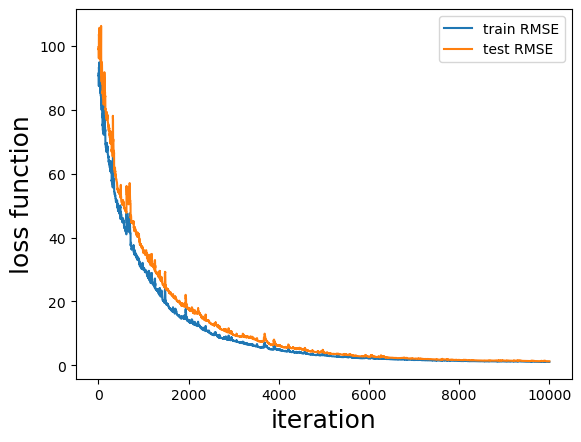

In [17]:
nb_of_iterations = 10000
step_size = 0.1

W_opt_full_gd,iteration,loss_function_train_array_full_gd, loss_function_test_array_full_gd  = batch_gradient_descent(X_train_small,Y_train_small,X_test_small, Y_test_small, nb_of_iterations, step_size, batch_percentage=0.0001)

plt.plot(iteration, loss_function_train_array_full_gd, label = "train RMSE")
plt.plot(iteration, loss_function_test_array_full_gd, label = "test RMSE")
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

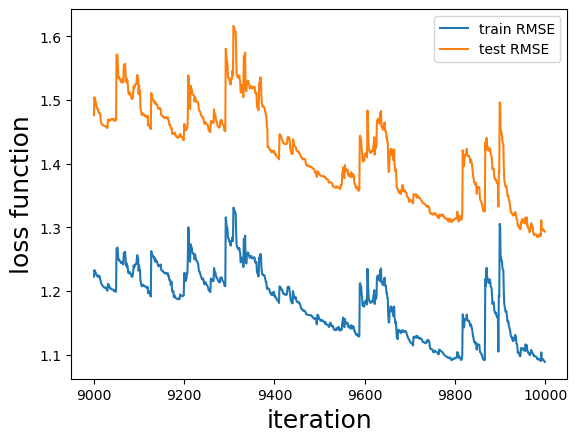

In [18]:
#last iterations
plt.plot(iteration[-1000:], loss_function_train_array_full_gd[-1000:], label = "train RMSE")
plt.plot(iteration[-1000:], loss_function_test_array_full_gd[-1000:], label = "test RMSE")
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

##### a. Test on a single word

In [19]:
# printing nearest neighbors in the target space
#the word to test needs to be in the whole elements of words, otherwise it's impossible to find a translation
word_to_test = words_test[2,0]
get_nn_scores(embedding_model_source = ft_en, word = word_to_test , words_data = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, K=5, epsilon = 1e-7)

Nearest neighbors of "chat":
0.4201 - rencontrer
0.3976 - conversation
0.3966 - rencontre
0.3966 - rencontre
0.3966 - rencontre


##### b. Test on the whole test set

In [20]:
good_translation_5 = test_translation(embedding_model_source = ft_en, words_test = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, limit=3000, K=5)
accuracy_5 = np.sum(good_translation_5)/len(good_translation_5)*100
print(f"The P5 accuracy is {round(accuracy_5,2)} %")

The P5 accuracy is 44.8 %


In [21]:
good_translation_1 =  test_translation(embedding_model_source = ft_en, words_test = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, limit=3000, K=1)
accuracy_1 = np.sum(good_translation_1)/len(good_translation_1)*100
print(f"The P1 accuracy is {round(accuracy_1,2)} %")

The P1 accuracy is 23.33 %


### 1. Gradient descent with Euler distance and no constraints (GD)

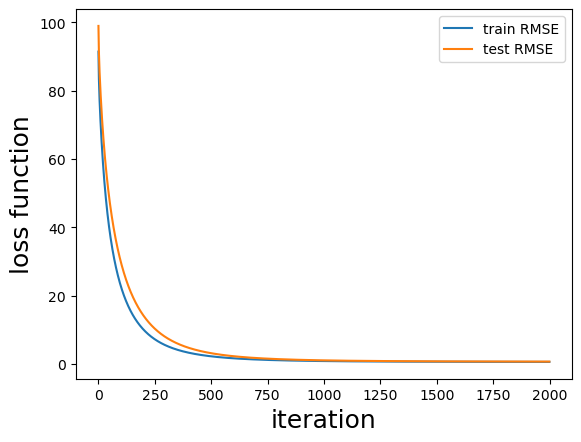

In [9]:
nb_of_iterations = 2000
step_size = 1

W_opt_full_gd,iteration,loss_function_train_array_full_gd, loss_function_test_array_full_gd  = gradient_descent(X_train_small,Y_train_small,X_test_small, Y_test_small, nb_of_iterations, step_size)

plt.plot(iteration, loss_function_train_array_full_gd, label = "train RMSE")
plt.plot(iteration, loss_function_test_array_full_gd, label = "test RMSE")
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()

##### a. Test on a single word

In [10]:
# printing nearest neighbors in the target space
#the word to test needs to be in the whole elements of words, otherwise it's impossible to find a translation
word_to_test = words_test[2,0]
get_nn_scores(embedding_model_source = ft_en, word = word_to_test , words_data = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, K=5, epsilon = 1e-7)

Nearest neighbors of "chat":
0.5471 - conversation
0.5453 - mail
0.5207 - discussion
0.5207 - discussion
0.4867 - dialoguer


##### b. Test on a the whole test set

In [11]:
good_translation_5 = test_translation(embedding_model_source = ft_en, words_test = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, limit=3000, K=5)
accuracy_5 = np.sum(good_translation_5)/len(good_translation_5)*100
print(f"The P5 accuracy is {round(accuracy_5,2)} %")

The P5 accuracy is 64.07 %


In [12]:
good_translation_1 =  test_translation(embedding_model_source = ft_en, words_test = words_test_full, tgt_emb = Y_test_full, W = W_opt_full_gd, limit=3000, K=1)
accuracy_1 = np.sum(good_translation_1)/len(good_translation_1)*100
print(f"The P1 accuracy is {round(accuracy_1,2)} %")

The P1 accuracy is 33.83 %
